## Overview

If you are planning on going out to see a movie, how well can you trust online reviews and ratings? *Especially* if the same company showing the rating *also* makes money by selling movie tickets. Do they have a bias towards rating movies higher than they should be rated?

### The Data

This is the data behind the story [Be Suspicious Of Online Movie Ratings, Especially Fandango’s](http://fivethirtyeight.com/features/fandango-movies-ratings/) openly available on 538's github: https://github.com/fivethirtyeight/data. There are two csv files, one with Fandango Stars and Displayed Ratings, and the other with aggregate data for movie ratings from other sites, like Metacritic,IMDB, and Rotten Tomatoes.

------
#### all_sites_scores.csv

`all_sites_scores.csv` contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango. The data from Fandango was pulled on Aug. 24, 2015.

Column | Definition
--- | -----------
FILM | The film in question
RottenTomatoes | The Rotten Tomatoes Tomatometer score  for the film
RottenTomatoes_User | The Rotten Tomatoes user score for the film
Metacritic | The Metacritic critic score for the film
Metacritic_User | The Metacritic user score for the film
IMDB | The IMDb user score for the film
Metacritic_user_vote_count | The number of user votes the film had on Metacritic
IMDB_user_vote_count | The number of user votes the film had on IMDb

----
----

#### fandango_scape.csv

`fandango_scrape.csv` contains every film 538 pulled from Fandango.

Column | Definiton
--- | ---------
FILM | The movie
STARS | Number of stars presented on Fandango.com
RATING |  The Fandango ratingValue for the film, as pulled from the HTML of each page. This is the actual average score the movie obtained.
VOTES | number of people who had reviewed the film at the time we pulled it.

In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [370]:
fd = pd.read_csv('fandango_scrape.csv')
all_sites = pd.read_csv('all_sites_scores.csv')

#### Rounding Off
Fandango claims to round its ratings to the nearest half integer to calculate the stars to give to a particular film. To make things fair, we shall first normalise the other three websites' ratings to a 5-point scale and round them off to the nearest half-integer

In [371]:
def round_half_integer(x):
    if(abs(x - round(x))==0.5):
        return x
    if(x-round(x)>0):
        return round(x)+0.5
    if(x-round(x)<0):
        return round(x)-0.5
    return x

all_sites['RT_Norm'] = np.vectorize(round_half_integer)(all_sites['RottenTomatoes']/20)
all_sites['RTU_Norm'] = np.vectorize(round_half_integer)(all_sites['RottenTomatoes_User']/20)
all_sites['MC_Norm'] = np.vectorize(round_half_integer)(all_sites['Metacritic']/20)
all_sites['MCU_Norm'] = np.vectorize(round_half_integer)(all_sites['Metacritic_User']/2)
all_sites['IMDB_Norm'] = np.vectorize(round_half_integer)(all_sites['IMDB']/2)

### Fandango
Let us first analyse the trends in the database from Fandango.

First up is a comparison of the ratings and stars on fandango.

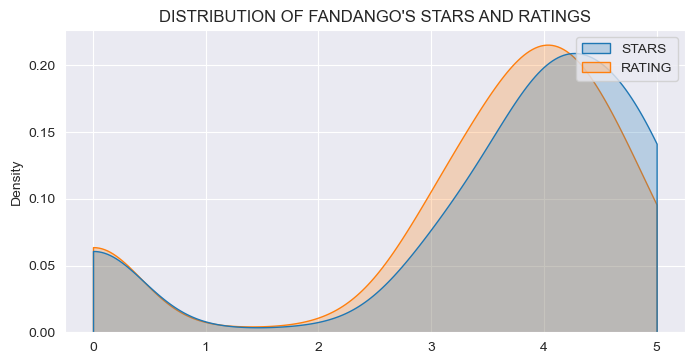

In [338]:
plt.figure(figsize=(8,4),dpi=100)
ax = sns.kdeplot(data=fd[['STARS','RATING']],shade=True,clip=[0,5])
ax.set(title='DISTRIBUTION OF FANDANGO\'S STARS AND RATINGS')
plt.show()

Ideally, these two curves should be the same. A website's stars system should be representative of the ratings given to the movies by its users. But in this case, the actual number of stars given to a movie seems to be, on an average, 0.2-0.3 more than the ratings provided. This is certainly not a green flag.

As mentioned earlier, Fandango claims to round off its user ratings to the nearest half integer to decide the number of stars. Thus, if we round off the user ratings column, we should get exactly the same values as the actual stars column. Let's see how the two compare in the case of Fandango

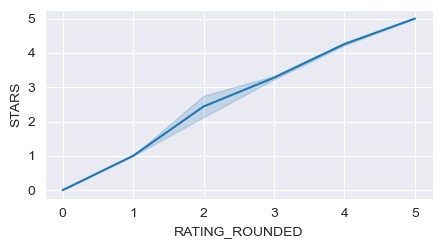

In [341]:
plt.figure(figsize=(5,2.5),dpi=100)
fd['RATING_ROUNDED'] = round(fd['RATING'])
sns.lineplot(x = 'RATING_ROUNDED', y = 'STARS', data=fd)
plt.show()

The relationship is linear, but with a few ups and downs somewhere around the 1.5 - 3 range. Interesting. This means that despite claiming to have its user ratings rounded off to calculate the number of stars for a movie, there are still some errors in that department for fandango, as the rounded off values don't quite line up perfectly with the stars alotted.

Let us analyse difference between the rounded off values and the stars to gain a better insight into the deviation on the above graph

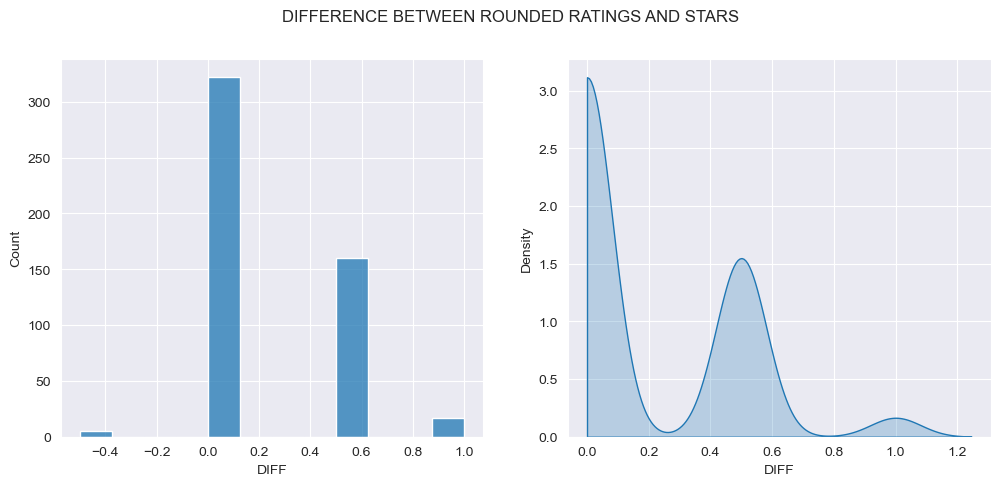

In [361]:
fig, axes = plt.subplots(figsize=(12,5),dpi=100,nrows=1,ncols=2)
fig.suptitle('DIFFERENCE BETWEEN ROUNDED RATINGS AND STARS')
fd['DIFF'] = fd['STARS'] - fd['RATING_ROUNDED']
sns.histplot(fd['DIFF'],ax=axes[0])
sns.kdeplot(fd['DIFF'],shade=True,clip=[0,5],ax=axes[1])
plt.show()

What do these graphs tell us ? 

#### In the left plot 
On the x-axis we have the difference between the number of stars given to a movie by fandango, and on the y-axis we have the number of movies for which this difference was observed. 
To put it in a nutshell, a total of over 150 movies are rated more than 0.5 stars higher than they should be. In fact, a few movies also have a difference of over a whole star in their favour.

#### In the right plot
This graph represents a more continous distribution of the star-ratings difference across movies. Ideally, this grouph should be centred around the 0 mark. But in our case, a significant proportion of the movies lies in the 0.4 - 0.6 range, meaning that many movies are rated about 0.4 - 0.6 stars higher than they should be

To further confirm this discrepancy, let us analyze the number of movies falling into different star ratings and the ratings we calculated by rounding off

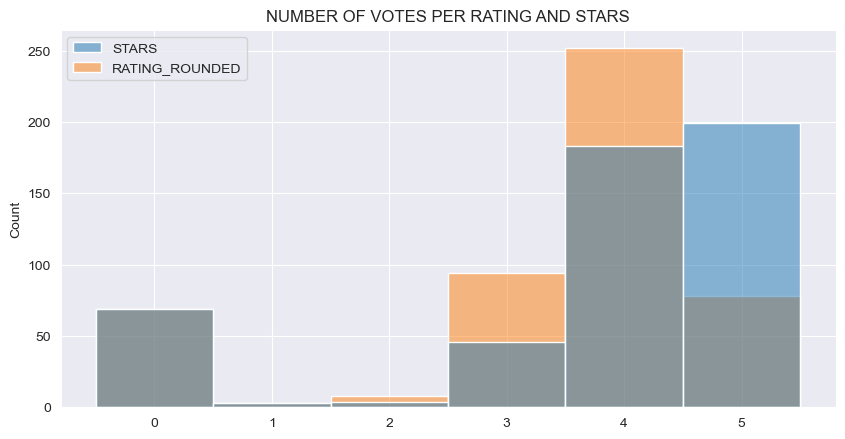

In [352]:
plt.figure(dpi=100,figsize=(10,5))
sns.histplot(data=fd[['STARS','RATING_ROUNDED']],
             lw=1,
             discrete=True,
             edgecolor='white',
             alpha=0.5).set(title='NUMBER OF VOTES PER RATING AND STARS')
plt.show()

Here on the horizontal axis we have the possible ratings for a movie.

The orange bar shows the number of movies that should be having that number of stars if the ratings were accurately rounded off, and the blue bar shows how many movies actually have that many stars. 

As can be seen, where a little less than a hundred movies should be in the 5-star category, the actual number is roughly 200. Whereas in the 4-star and 3-star category, the actual number falls behind the calculated ideal numbers by a significant margin.




#### With this, we have confirmed that even in the Fandango database, there are major discrepancies and a lot of movies ( > 20%) have a higher star rating compared to their user ratings, even when rounded off.

## OTHER WEBSITES
Moving on to comparing the rest of the websites, namely Rotten Tomatoes, Metacritic and IMDB among themselves.

### User vs Critics
Rotten Tomatoes and Metacritic, both provide critic review as well as user review for each of their movies. Let's see how the general opinion lines up with that of the critics for both these  websites.

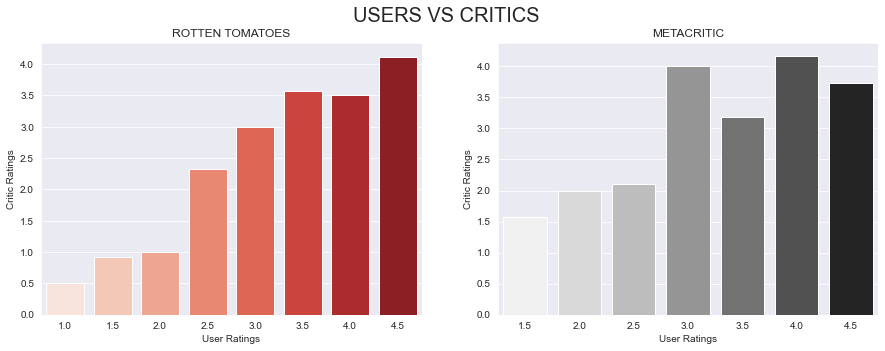

In [243]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle('USERS VS CRITICS',fontsize=20)

sns.barplot(y = 'RT_Norm', 
                x = 'RTU_Norm', 
                data = all_sites,
                ax=axes[0],
           ci=0,
           palette='Reds').set(title='ROTTEN TOMATOES',xlabel='User Ratings',ylabel='Critic Ratings')

sns.barplot(y = 'MC_Norm', 
                x = 'MCU_Norm', 
                data = all_sites,
                ax=axes[1],
                color='orange',
                ci = 0,
           palette='Greys').set(title='METACRITIC',xlabel='User Ratings',ylabel='Critic Ratings')
plt.show()

Both these graphs somewhat stick to the expected trends, with Rotten Tomatoes being more accurate in that regard, as the average critic ratings line up quite welll with the average user ratings. As far as metacritic is concerned, the difference is considerably larger than that in the case of Rotten Tomatoes, and the critics ratings are more evenly spread out around the 3-4.5 user ratings mark.

Notice how neither of the two websites have any movie rated higer than 4.5 stars by users or by critics.

### Vote Distribution
IMDB's and Metacritic's data provide us with the total number of votes that were counted for all their movies.This is an interesting statistic and analyzing how ratings change with increasing number of votes may provide some insight.

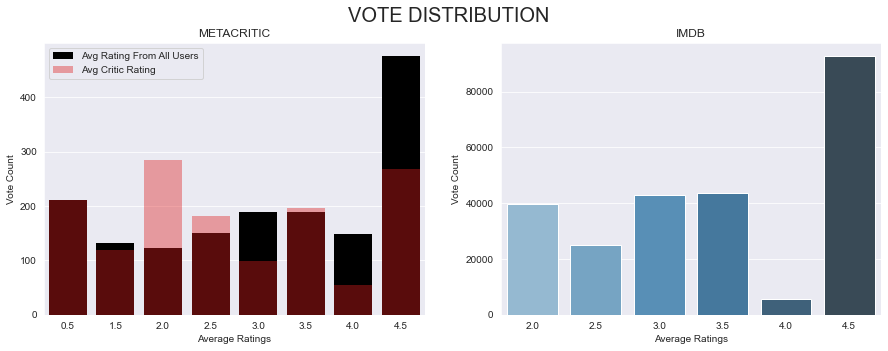

In [302]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle('VOTE DISTRIBUTION',fontsize=20)

all_sites['MC_Avg'] = np.vectorize(round_half_integer)((all_sites['MC_Norm']+all_sites['MCU_Norm'])/2)
sns.barplot(y='Metacritic_user_vote_count',
            x='MC_Avg',
             data = all_sites,
             ax=axes[0],
             lw = 0,
           ci = 0,
           color='Black',
           label = 'Avg Rating From All Users')

sns.barplot(y='Metacritic_user_vote_count',
            x='MC_Norm',
             data = all_sites,
             ax=axes[0],
             lw = 0,
           ci=0,
           color='red',
           alpha=0.4,
           label = 'Avg Critic Rating')
axes[0].legend()
axes[0].set_xlabel('Average Ratings')
axes[0].set_ylabel('Vote Count')
axes[0].set_title('METACRITIC')

sns.barplot(y = 'IMDB_user_vote_count', 
                x = 'IMDB_Norm', 
                data = all_sites,
                ax=axes[1],
                color='grey',
                palette = 'Blues_d',
               ci=0).set(title='IMDB',xlabel='Average Ratings',ylabel='Vote Count')
plt.show()

Since Metacritic has separate critic reviews and user reviews as well, we have analyzed the average critic score as well as the overall average score for Metacritic.

As far as the Metacritic critic reviews are concerned, they are  more or less evenly spread out across different ratings, with neither rating showing an unusual spike. this goes on to show how Metacritic's critics are unbiased in their opinions and don't rate movies unnecessarilly higher or lower.

For the overall average in both the cases, the distribution is fairly even. Except this time both seem to have a spike of votes for the highest-rated movies (4.5 stars). While this may seem unnatural at first, it is the expected result because as far as the general public is concerned, one is more likely to take the effort to log in to the website and vote for a movie if they like it a lot.

### Fandango vs Average

Having confirmed that data from the other websites contains no major unexpected results or trends, we now move on to compare this data with that in the Fandango database.

We start by comparing how the different average scores are distributed throughout the different movies. We take the overall average (AVG), the critics' average (AVG_Critic) and the users' average (AVG_User) from Rotten Tomatoes, Metacritic and IMDB. On the other hand, we take Fandango's average star-rating (AVG_Fandango).
We take these values for all the movies present in both databases.

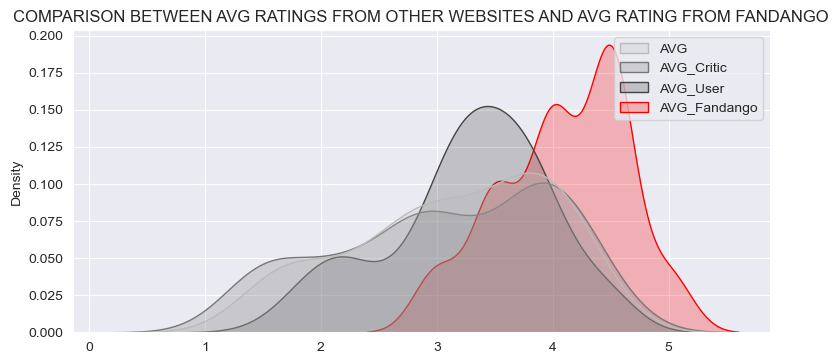

In [330]:
plt.figure(figsize=(9,4),dpi=100)
scores = pd.merge(fd,all_sites,on='FILM',how='inner')[['RATING','STARS','RT_Norm','RTU_Norm','MC_Norm','MCU_Norm','IMDB_Norm']]
scores['AVG'] = (scores['RT_Norm']+scores['RTU_Norm']+scores['MC_Norm']+scores['MCU_Norm']+scores['IMDB_Norm'])/5
scores['AVG_Critic'] = (scores['RT_Norm']+scores['MC_Norm']+scores['IMDB_Norm'])/3
scores['AVG_User'] = (scores['RTU_Norm']+scores['MCU_Norm']+scores['IMDB_Norm'])/3
scores.rename(columns={"STARS":"AVG_Fandango"},inplace=True)
sns.kdeplot(data=scores[['AVG','AVG_Critic','AVG_User','AVG_Fandango']],shade=True,palette=['#BBBBBB','#777777','#444444','red']).set(title='COMPARISON BETWEEN AVG RATINGS FROM OTHER WEBSITES AND AVG RATING FROM FANDANGO')
plt.show()

The red shade indicates average score from Fandango for each movie.

Note how the other three average ratings line up somewhat on top of each other, with the users' ratings being more centred towards the 3.5 mark and the critics' average being spread out evenly. This is only natural as general public tends to rate a movie more leniently as comapred to professional critics.

But Fandango's average, on the other hand, shows a completely different trend. A vast majority of Fandango movies are in the 4-5 range, while the other three shades have little area in that range.

To get a better idea of the numbers, we compare the number of movies having different overall average ratings and Fandango ratings

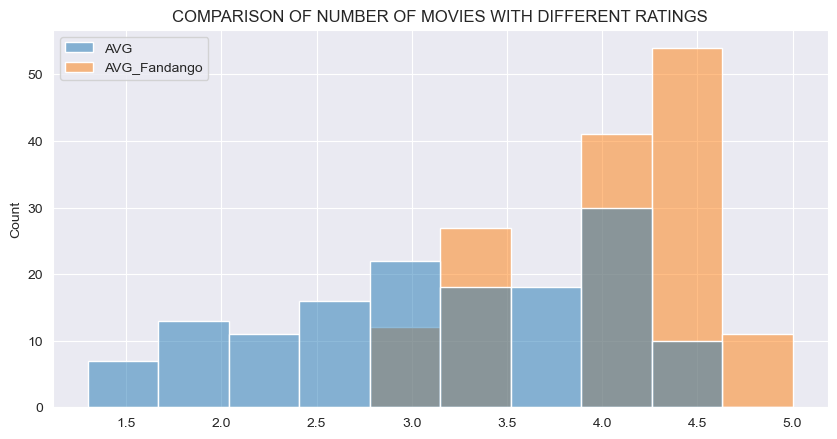

In [362]:
plt.figure(figsize=(10,5),dpi=100)
sns.histplot(data = scores[['AVG','AVG_Fandango']],alpha=0.5).set(title='COMPARISON OF NUMBER OF MOVIES WITH DIFFERENT RATINGS')
plt.show()

The overall average ratings tend to be evenly distributed and has no significant hikes. To put this into perpective, the number of movies having an average rating of 3 is roughly the same as the number of movies having average rating 4.

While for Fandango, it is once again a completely different story. No movies have a score below 2.5. Even after that, the distribution is heavily centred at 4.5, meaning that most Fandango movies are rated in the 4-5 range.

Now that we know that Fandango's ratings do, indeed, differ quite a lot from the overall average, let's see if the rest of the websites are able to keep up with this average without showing much bias.

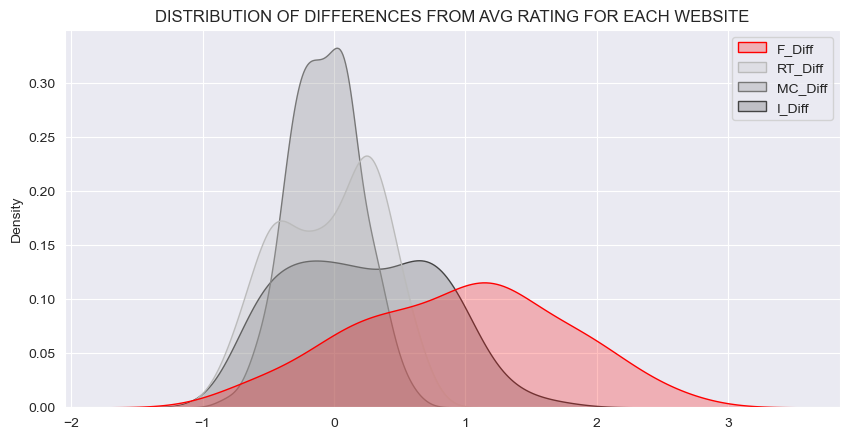

In [364]:
plt.figure(figsize=(10,5),dpi=100)
scores['F_Diff'] = scores['AVG_Fandango']-scores['AVG']
scores['RT_Diff'] = (scores['RT_Norm']+scores['RTU_Norm'])/2 - scores['AVG']
scores['MC_Diff'] = (scores['MC_Norm']+scores['MCU_Norm'])/2 - scores['AVG']
scores['I_Diff'] = scores['IMDB_Norm'] - scores['AVG']
sns.kdeplot(data = scores[['F_Diff','RT_Diff','MC_Diff','I_Diff']],shade=True,palette=['red','#BBBBBB','#777777','#444444']).set(title='DISTRIBUTION OF DIFFERENCES FROM AVG RATING FOR EACH WEBSITE')
plt.show()

In the above graph, we can see  the deviations from the average ratings for all movies on the three websites. The horizontal axis corresponds to this difference, while the vertical axis corresponds to the proportion of movies having a\that particular difference in ratings.

The graphs for Rotten Tomatoes, Metacritic and IMDB are clearly centred around the 0 mark. This is ideal as on an average, there should be no bias and the deviation from overall average should be 0 for  any website.

But in the case of Fandango, the distribution seems to be more centred around the 1 star mark instead of the 0 mark. This implies that most Fandango movies are rated about 1 star higher than the overall average of the other websites

Finally, we now see the bigger picture and compare the deviations from average ratings, averaged over all the movies for the four websites.

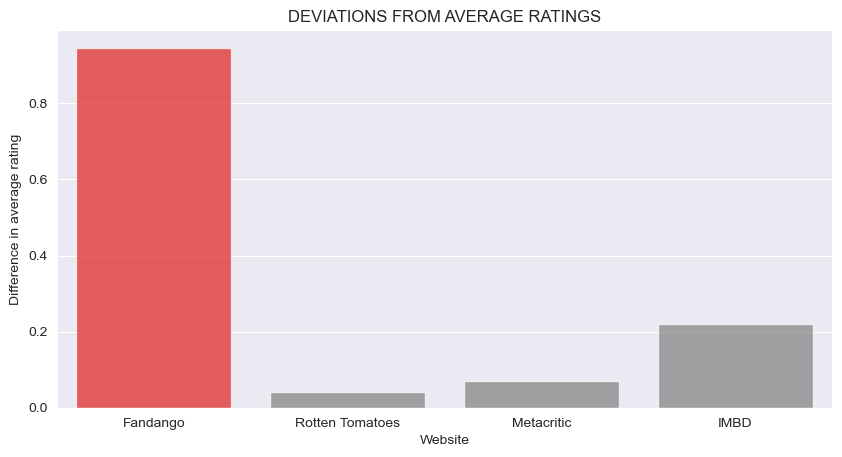

In [368]:
diff = {
    'Fandango' : abs(scores['F_Diff'].mean()),
    'Rotten Tomatoes': abs(scores['RT_Diff'].mean()),
    'Metacritic': abs(scores['MC_Diff'].mean()),
    'IMBD': abs(scores['I_Diff'].mean())
}

diff = pd.Series(diff)
diff = pd.DataFrame(diff)
diff = diff.reset_index()
diff.rename(columns={'index':'Website', 0:'Difference in average rating'},inplace=True)
sns.set_style('darkgrid')
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(x='Website',y='Difference in average rating',data=diff,palette=['red','grey','grey','grey'],alpha=0.7).set(title='DEVIATIONS FROM AVERAGE RATINGS')
plt.show()

### Conclusion

The bias in Fandango's rating is clearly visible in this figure. On average, Fandango rates each movie almost a whole star higher than the overall average.